<a href="https://colab.research.google.com/github/irinaachikhmina/Triplexes/blob/main/1_01_Triplex_regions_hg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recognition of Triplex Target Sites within DNA Using Omics Data

##Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c bioconda bedtools

In [ ]:
!pip install biopython

In [ ]:
!pip install pybedtools
from pybedtools import BedTool

In [ ]:
import pandas as pd
import numpy as np
import math
import pickle
from tqdm.notebook import tqdm
from random import sample

import seaborn as sns
import matplotlib.pyplot as plt

import Bio
from Bio import SeqIO

In [ ]:
sns.set(font_scale=1)
sns.set_style("ticks") 

#Human genome HG38

release 109 dated 2022-12-13

In [ ]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]

In [ ]:
!gunzip '/content/drive/MyDrive/Triplexes/data/hg38'/*

In [ ]:
chroms = {}

for name in tqdm(chrom_names):
    chroms[name] = SeqIO.read('/content/drive/MyDrive/Triplexes/data/hg38/' 
                              + 'Homo_sapiens.GRCh38.dna.' 
                              + name[:3] 
                              + 'omosome.' 
                              + name[3:] 
                              + '.fa', 
                              'fasta')

  0%|          | 0/24 [00:00<?, ?it/s]

#Triplex DNA regions

##Experimental data

Triplex DNA regions from Kouzine and Wojtowicz work (Kouzine F, Wojtowicz D, Baranello L, et al. Permanganate/S1 Nuclease Footprinting Reveals Non-B DNA Structures with Regulatory Potential across a Mammalian Genome. Cell Syst. 2017;4(3):344-356.e7. doi:10.1016/j.cels.2017.01.013)

In [ ]:
!gdown https://www.ncbi.nlm.nih.gov/CBBresearch/Przytycka/software/nonbdna/nonB_DNA_ssDNA_enriched.tar

Downloading...
From: https://www.ncbi.nlm.nih.gov/CBBresearch/Przytycka/software/nonbdna/nonB_DNA_ssDNA_enriched.tar
To: /content/nonB_DNA_ssDNA_enriched.tar
1.50MB [00:00, 12.7MB/s]


In [ ]:
!tar -xvf '/content/nonB_DNA_ssDNA_enriched.tar'

nonB_DNA_ssDNA_enriched/
nonB_DNA_ssDNA_enriched/human_hg19/
nonB_DNA_ssDNA_enriched/human_hg19/Raji_ssDNA_enriched_H-DNA.bed.gz
nonB_DNA_ssDNA_enriched/human_hg19/Raji_ssDNA_enriched_Quadruplex.bed.gz
nonB_DNA_ssDNA_enriched/human_hg19/Raji_ssDNA_enriched_SIDD.bed.gz
nonB_DNA_ssDNA_enriched/human_hg19/Raji_ssDNA_enriched_Z-DNA.bed.gz
nonB_DNA_ssDNA_enriched/mouse_mm9/
nonB_DNA_ssDNA_enriched/mouse_mm9/actB_ssDNA_enriched_H-DNA.bed.gz
nonB_DNA_ssDNA_enriched/mouse_mm9/actB_ssDNA_enriched_Quadruplex.bed.gz
nonB_DNA_ssDNA_enriched/mouse_mm9/actB_ssDNA_enriched_SIDD.bed.gz
nonB_DNA_ssDNA_enriched/mouse_mm9/actB_ssDNA_enriched_Z-DNA.bed.gz


In [ ]:
GF = BedTool('/content/nonB_DNA_ssDNA_enriched/human_hg19/Raji_ssDNA_enriched_H-DNA.bed.gz')
len(GF)

8356

##Assembly convertion to hg38

liftOver site at https://genome.ucsc.edu/cgi-bin/hgLiftOver

In [ ]:
GF = BedTool('/content/drive/MyDrive/Triplexes/data/hglft_genome_2e58e_4a1a80.bed')
len(GF)

8341

15 regions deleted in new assembly

In [ ]:
length =[]
for el in GF:
    length.append(el.end - el.start)

print('Number of regions:', len(GF))
print('Average length of region:', round(sum(length) / len(length)))
print('Max length of region:', round(max(length)))
print('Min length of region:', round(min(length)))
print('First line:', GF[0])

Number of regions: 8341
Average length of region: 24
Max length of region: 132
Min length of region: 16
First line: chr1	888613	888633	chr1:823994-824013	1



##Filtering

Filtering for black-listed regions

In [ ]:
!gdown https://github.com/Boyle-Lab/Blacklist/raw/master/lists/hg38-blacklist.v2.bed.gz

Downloading...
From: https://github.com/Boyle-Lab/Blacklist/raw/master/lists/hg38-blacklist.v2.bed.gz
To: /content/hg38-blacklist.v2.bed.gz
100% 5.87k/5.87k [00:00<00:00, 3.60MB/s]


In [ ]:
int = !bedtools intersect -a '/content/drive/MyDrive/Triplexes/data/hglft_genome_2e58e_4a1a80.bed' -b '/content/hg38-blacklist.v2.bed.gz'
len(int)

130

In [ ]:
GF = !bedtools subtract -a '/content/drive/MyDrive/Triplexes/data/hglft_genome_2e58e_4a1a80.bed' -b '/content/hg38-blacklist.v2.bed.gz'
len(GF)

8211

In [ ]:
130/8341

0.015585661191703633

In [ ]:
GF = BedTool(GF)
length =[]
for el in GF:
    length.append(el.end - el.start)

print('Number of regions:', len(GF))
print('Average length of region:', round(sum(length) / len(length)))
print('Max length of region:', round(max(length)))
print('Min length of region:', round(min(length)))
print('First line:', GF[0])

Number of regions: 8211
Average length of region: 24
Max length of region: 132
Min length of region: 16
First line: chr1	888613	888633	chr1:823994-824013	1



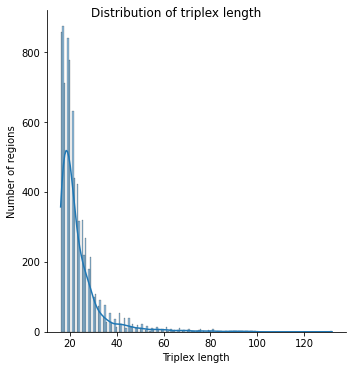

In [ ]:
ax = sns.displot(length, kde=True)
ax.set_axis_labels("Triplex length", "Number of regions")
ax.fig.suptitle('Distribution of triplex length')
#ax.set_titles("Distribution of triplex length")
plt.show()

Examination of longest regions

In [ ]:
for record in GF:
  if record.end - record.start > 90:
    print(chroms[record.chrom][record.start:record.end].seq)

AGAGAAAGATAGAGAGAGAGAGAGAGAGACAGACAGACAGAGAGAGAGAGAGAGAGACAGACAGACAGAGAGAGAGACAGACAGAGAGAGAGAGA
CCCTCCCCTCCCCTCCCCTCCCCCCTCCCCTCCCCTCCCCCCTCCCCTCCCCTCCCCCTTCCCCTCCCCCCCTCCCCTCCCCTCCCCTCCCCTCCC
CCTCTCCCTCTCCCTCCTCTCCCTCTCCCTCCTCTCCCTCTCCCTCCTCTCCCTCTCCCTCCTCTCCCTCTCCCTCCTCTCCCTCTCCCTCTCC
CCTCCTCCTTCTCCTCCTCCGCTGTCGCCTCCTCCTCCTCCTCCTCCTCCTCCTCCTCCTCCTCCTCCTCCGCTGTCGCCTCCTCCTCCTCCTCCTCC
TCTCTCTCTCTCTCTCTCTCTCTCTCCTCTCTCCTTCTCTCTCTCCTCTCTCTCTCCTCTCTCTCCTCTCTGTCTCTCTCTCTGTCTCTCT
AAAGAAAGAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAGAGAGAAA
AAGAAGGAAGAAGAAGGGAGAAGGAAGAAGGAGGAAGGAGGAAGAAGGAAGAAGAAGGAAGAAGGAGGAAGGAGGAAGAAGGAAGAAGAAGGAAGAA
CTCTCTCCCTCTCTCCCTCTCTCCCTCTCTCCCTCTCTCCCTCTCTCTCTCCCTCTCTCCCTCCCTCTCTCTCTCTCTCTCTCCCTCTCTC
GAGAGGTGGAGAGAGATGGAGAGAGGCGGAGAGAGGCGGAGAGAGACGGAGAGAGGTGGAGAGAGACGGAGAGAGGTGGAGAGAGATGGAGAG
AGAGAAAGAAAGAGAGAGAGAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAGAAAGAAAGAGA
CCTCCTCCTCCTCCTCTTCCTCCTCCTCCTCTTCCTCCTCCTCCT

Short regions

In [ ]:
for record in GF:
  leng = record.end - record.start
  if leng == 22:
    print(chroms[record.chrom][record.start:record.end].seq)

GGGAGGGGAAGAGAGGGGAGGG
TCCGCCCCCCCCCCCCCCGCCT
CCCTCCCCTCCGCTCCCCTCCC
TCTCCTTTCCCTCCTTTCCTCT
AGGAGGGGAGGGGAGGGGAGGA
AGGAGGAGGAAGAGGAGGAGGA
AGGGAGAGGGGGAGGAGAGGGA
TTTTTTTTTTTTTTTTTTTTTT
GGGAGGGAGAGAGGAGGGAGGG
AGGAGGAGGACGAGGAGGAGGA
CCCCCGCCCCCACCCCGCCCCC
CCCCTCCCCGCCCCCCCTCCCC
TCCCTGTCCCTGCCCTGTCCCT
AAAAAACAAAAAAAACAAAAAA
TTTTCTTTTTTCTTTTTCTTTT
TTTTTTTTTTTTTTTTTTTTTT
GGGGGGGGGTGGCGGGGGGGGG
CATTCTTTCTGATCTTTCTTAC
CGTTCTCTCCCTCCTCTCTTGC
TCTTCCTCCTCCTCCTCCTTCT
AAAAAAAAAAAAAAAAAAAAAA
CCTTTCCTCCCATCTCCTTTCC
TTTTTTTTTTTTTTTTTTTTTT
GGGAGGGGAGAGAAGGGGAGGG
CTCCCTTCCTTTGCCTTCCCTC
AAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAA
GGGAAGAGGGAAGGGAGAAGGG
TCTTTTTTTTTTTTTTTTCTCT
AAAAAAAGAAAAAAGAAAAAAA
ATCTTCCCTCCCCTCCCTTCTA
AAAAAAAAAAAAAAAAAAAAAA
CCCCGCCCCCCGCCCCCGCCCC
AAAAAAAAAAAAAAAAAAAAAA
CTCCTCTTCTTTTCTTCTCCTC
AGGAGGAGGAGGAGGAGGAGGA
CTCCTCCTCCGTCCTCCTCCTC
GAGAGAGAGATGAGAGAGAGAG
AAAAAAAAAAAAAAAAAAAAAA
TCCCTCCTCCCCCCTCCTCCCT
AGGGAGGGAGGGGAGGGAGGGA
AAAAAAAAAAAAAAAAAAAAAA
GGGGAGGGGGAGGGGGGAGGGG
GGGGAGGGGGA